# Non-stationary internal tide analysis of IMOS mooring data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
# import h5py
from scipy import signal



from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.utils.harmonic_analysis import harmonic_fit_array


import pymc3 as pm
from theano import shared
from theano import tensor as tt

import matplotlib as mpl

In [2]:
%matplotlib notebook

In [3]:
# Define functions here


def open_bfilt_dataset(ncfile, group, highT=3):
    """
    Load band-passed variable from a dataset
    """
    myds = xr.open_dataset(ncfile,group=group)['A_n']
    ts = timeseries(myds.time.values, myds.values)
    yfilt = ts.filt([34*3600,highT*3600], btype='band')
    myds.data[:]=yfilt.T
    return myds

def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[...,ii]*np.cos(omega[ii]*tdays) + Ba[...,ii]*np.sin(omega[ii]*tdays)
    
    return amp


In [4]:


figpath = '../FIGURES'

mode = 0

In [5]:



ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

sitename = 'KP150'
groups = ['KP150_phs1','KP150_phs2']
badtimes = [('2016-09-15','2016-10-31') ]
ylim = (-30,30)


# ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellPreludeRPS/Prelude_Fitted_Buoyancy.nc'
# sitename = 'FBlock'
# groups = ['F_Block_2007_CM04','F_Block_2008a_CM04','F_Block_2008b_CM04',
#           'F_Block_2009a_CM04','F_Block_2009b_CM04']
# badtimes = []
# ylim = (-30,30)


###
# ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/processed_data/IMOS_Fitted_Buoyancy_Tonly.nc'
# ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/IMOS/processed_data/IMOS_Fitted_Buoyancy_Deep_Tonly.nc'          

###
# sitename = 'PIL200'
# groups = ['PIL200_2012_a','PIL200_2012_b','PIL200_2013_a','PIL200_2013_b','PIL200_2014_a']
# # badtimes = [('2013-01-30','2013-04-01'),('2013-08-03','2013-08-05')]
# badtimes = []
# ylim = (-40,40)

# # ###
# sitename = 'KIM200'
# groups = ['KIM200_2012_a','KIM200_2012_b','KIM200_2013_a','KIM200_2013_b','KIM200_2014_a']
# badtimes = [ ('2012-05-25','2012-08-12'), ('2013-07-01','2013-07-25') ]
# # badtimes = []
# ylim = (-30,30)

# # ####
# sitename = 'KIM400'
# groups = ['KIM400_2012_a','KIM400_2012_b','KIM400_2013_a','KIM400_2013_b','KIM400_2014_a']
# badtimes = [ ('2012-07-30','2012-08-12'), ('2014-07-10','2014-08-25') ]
# ylim = (-30,30)

####
# Lots of bad values!!
# sitename = 'ITFMHB'
# groups = ['ITFMHB_2012_a','ITFMHB_2012_b','ITFMHB_2013_a','ITFMHB_2013_b','ITFMHB_2014_a']
# badtimes = [ ('2013-06-01','2013-11-18'),  ]
# ylim = (-30,30)

# sitename = 'ITFTIS'
# groups = [
#     #'ITFTIS_2010_b','ITFTIS_2011_b',
#     'ITFTIS_2012_a',
#     'ITFTIS_2012_b',
#     'ITFTIS_2013_a',
#     'ITFTIS_2013_b',
#     'ITFTIS_2014_a',
#     #'ITFTIS_2014_b','ITFTIS_2015_a','ITFTIS_2015_b',
#     ]
# #badtimes = [ ('2012-01-07','2012-01-13'),  ]
# badtimes=[]
# ylim = (-30,30)

# Load the data
ds = xr.concat([open_bfilt_dataset(ncfile, gg, highT=6) for gg in groups], dim='time')
ds3 = xr.concat([open_bfilt_dataset(ncfile, gg, highT=3) for gg in groups], dim='time')

dsA = xr.concat([xr.open_dataset(ncfile,group=gg)['A_n'] for gg in groups], dim='time')
dsAt = xr.concat([xr.open_dataset(ncfile,group=gg)['Atide'] for gg in groups], dim='time')


dsN = xr.concat([xr.open_dataset(ncfile,group=gg)['N2'] for gg in groups], dim='timeslow')
dsphi = xr.concat([xr.open_dataset(ncfile,group=gg)['phi'] for gg in groups], dim='timeslow')

dsamp = xr.concat([xr.open_dataset(ncfile,group=gg)['amp'][::4,...] for gg in groups], dim='timeslow')
dsphs = xr.concat([xr.open_dataset(ncfile,group=gg)['phs'][::4,...] for gg in groups], dim='timeslow')

# Mask out bad times
for bt in badtimes:
    t1,t2 = bt
    ds.loc[t1:t2]=np.nan
    ds3.loc[t1:t2]=np.nan
    dsA.loc[t1:t2]=np.nan
    dsamp.loc[t1:t2] = np.nan
    dsphs.loc[t1:t2] = np.nan

z = dsN.z.values

dsamp_re = dsamp*np.cos(dsphs)
dsamp_im = dsamp*np.sin(dsphs)

<IPython.core.display.Javascript object>


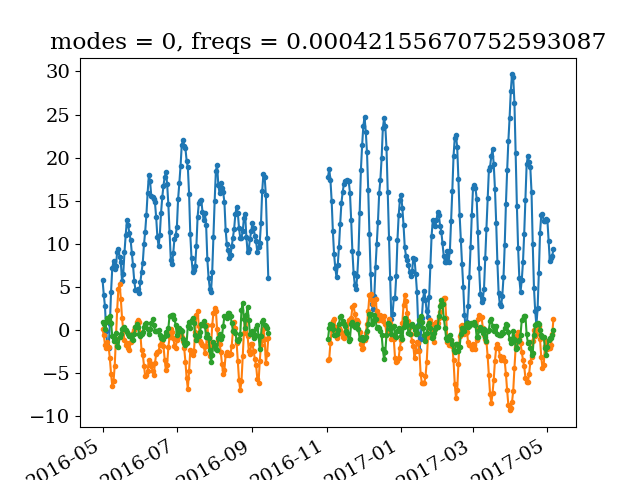

In [6]:
plt.figure()
dsamp_re[:,mode,0].plot(marker='.',)
dsamp_re[:,mode,1].plot(marker='.',)
dsamp_re[:,mode,2].plot(marker='.',)

In [37]:
def harmonic_gp_mcmc(dtime, X ):
    """
    Harmonic fitting using Bayesian inference
    """

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        #beta_mean = pm.Normal('beta_mean', mu=0, sd=10)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)
        
        #y_mu = beta_mean + beta_linear*dtime[:,None]

        #sigma = pm.HalfCauchy("sigma", beta=10.0)
        #y_ = pm.Normal('y',mu=y_mu,sigma=sigma, observed = y_mu)
        # GP
        #ℓ = BoundNormal("ℓ", mu=10000,sd=10000)
        #ℓ = pm.Gamma("ℓ", alpha=0.1,beta=0.5)
        ℓ = pm.HalfNormal("ℓ", sd=1.)
        ℓ2 = pm.HalfNormal("ℓ2", sd=1.)


        #T = pm.Gamma("T", alpha=1.,beta=2.)
        T = 14.78
        #η = pm.HalfCauchy("η", beta=1.)
        η = pm.HalfNormal("η", sd=10.)

        cov = η**2 * pm.gp.cov.Periodic(1, T, ls=ℓ)
        cov *= pm.gp.cov.Matern52(1, ℓ2)

        sigma = pm.HalfCauchy("sigma", beta=10.0)

        # Marginal GP implementation
        #gp= pm.gp.Marginal(cov_func=cov, ) # No mean
        #gp= pm.gp.Marginal(cov_func=cov,)
        #y_ = gp.marginal_likelihood("y", X=dtime[:,None], y=X, noise=sigma)
        
        gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

        # initialize 20 inducing points with K-means
        # gp.util
        Xu = pm.gp.util.kmeans_inducing_points(20, dtime[:,None])
        y_ = gp.marginal_likelihood("y", X=dtime[:,None], y=X, Xu=Xu, noise=sigma)

        
        #mp = pm.find_MAP()
        #print(mp)
        mp = None
        #gp = None

        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        
        trace = pm.sample(500, tune=1500, start = start, step=step, cores=2,)
        #                 )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
        
    # Calculate statistics of the inferred parameters
    def trace_sd(x):
        return pd.Series(np.std(x, 0), name='sd')
    def trace_mean(x):
        return pd.Series(np.mean(x, 0), name='mean')
    def trace_quantiles(x):
        return pd.DataFrame(pm.quantiles(x, [5, 50, 95]))
    

    params = pm.summary(trace, stat_funcs=[trace_mean, trace_sd, trace_quantiles])
    #trace = None
    #params = None
    
    # Return the trace and the parameter stats
    return trace, params, my_model, gp, mp
    

In [51]:
dtime = SecondsSince(dsamp_re.timeslow.values, basetime=datetime(2016,1,1)) / 86400.
a0 = dsamp_re[:,mode,0].values
idx = ~np.isnan(a0)

Xmu = np.mean(a0[idx])
Xstd = np.std(a0[idx])

trace, params, my_model, gp, mp = harmonic_gp_mcmc(dtime[idx], (a0[idx]-Xmu)/Xstd,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, η, ℓ2, ℓ]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:25<00:00, 19.49draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [39]:
params

mean        sd         5        50         95
ℓ      2.317503  0.464280  1.646501  2.273968   3.137400
ℓ2     7.251962  0.474236  6.494569  7.239468   8.060496
η      9.624005  0.686722  8.465044  9.633710  10.737028
sigma  2.170479  0.554697  1.334143  2.120695   3.120015

In [52]:
# add the GP conditional to the model, given the new X values
with my_model:
    f_pred = gp.conditional("f_pred", dtime[:,None])

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with my_model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=500)


100%|██████████| 500/500 [01:23<00:00,  5.98it/s]


<IPython.core.display.Javascript object>


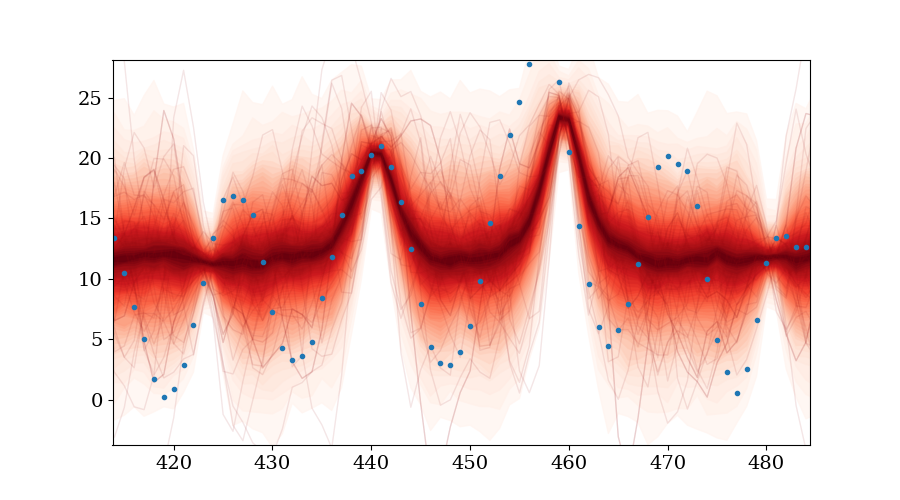

In [55]:
fig = plt.figure(figsize=(9,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
pm.gp.util.plot_gp_dist(ax, pred_samples["f_pred"]*Xstd+Xmu, dtime)
plt.plot(dtime,a0,'.')